In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import os
import imageio
from IPython.display import Image, display

sns.set()

# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default') 

print( f"Python {sys.version}" )
print( f"Pandas {pd.__version__}" )
print( f"NumPy {np.__version__}" )
print( f"Matplotlib {mpl.__version__}" )

Python 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
Pandas 1.3.4
NumPy 1.20.3
Matplotlib 3.4.3


In [2]:
#set encoding to ignore special charaters
satellite = pd.read_csv("space_missions.csv",encoding="ISO-8859-1")
satellite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company        4630 non-null   object
 1   Location       4630 non-null   object
 2   Date           4630 non-null   object
 3   Time           4503 non-null   object
 4   Rocket         4630 non-null   object
 5   Mission        4630 non-null   object
 6   RocketStatus   4630 non-null   object
 7   Price          1265 non-null   object
 8   MissionStatus  4630 non-null   object
dtypes: object(9)
memory usage: 325.7+ KB


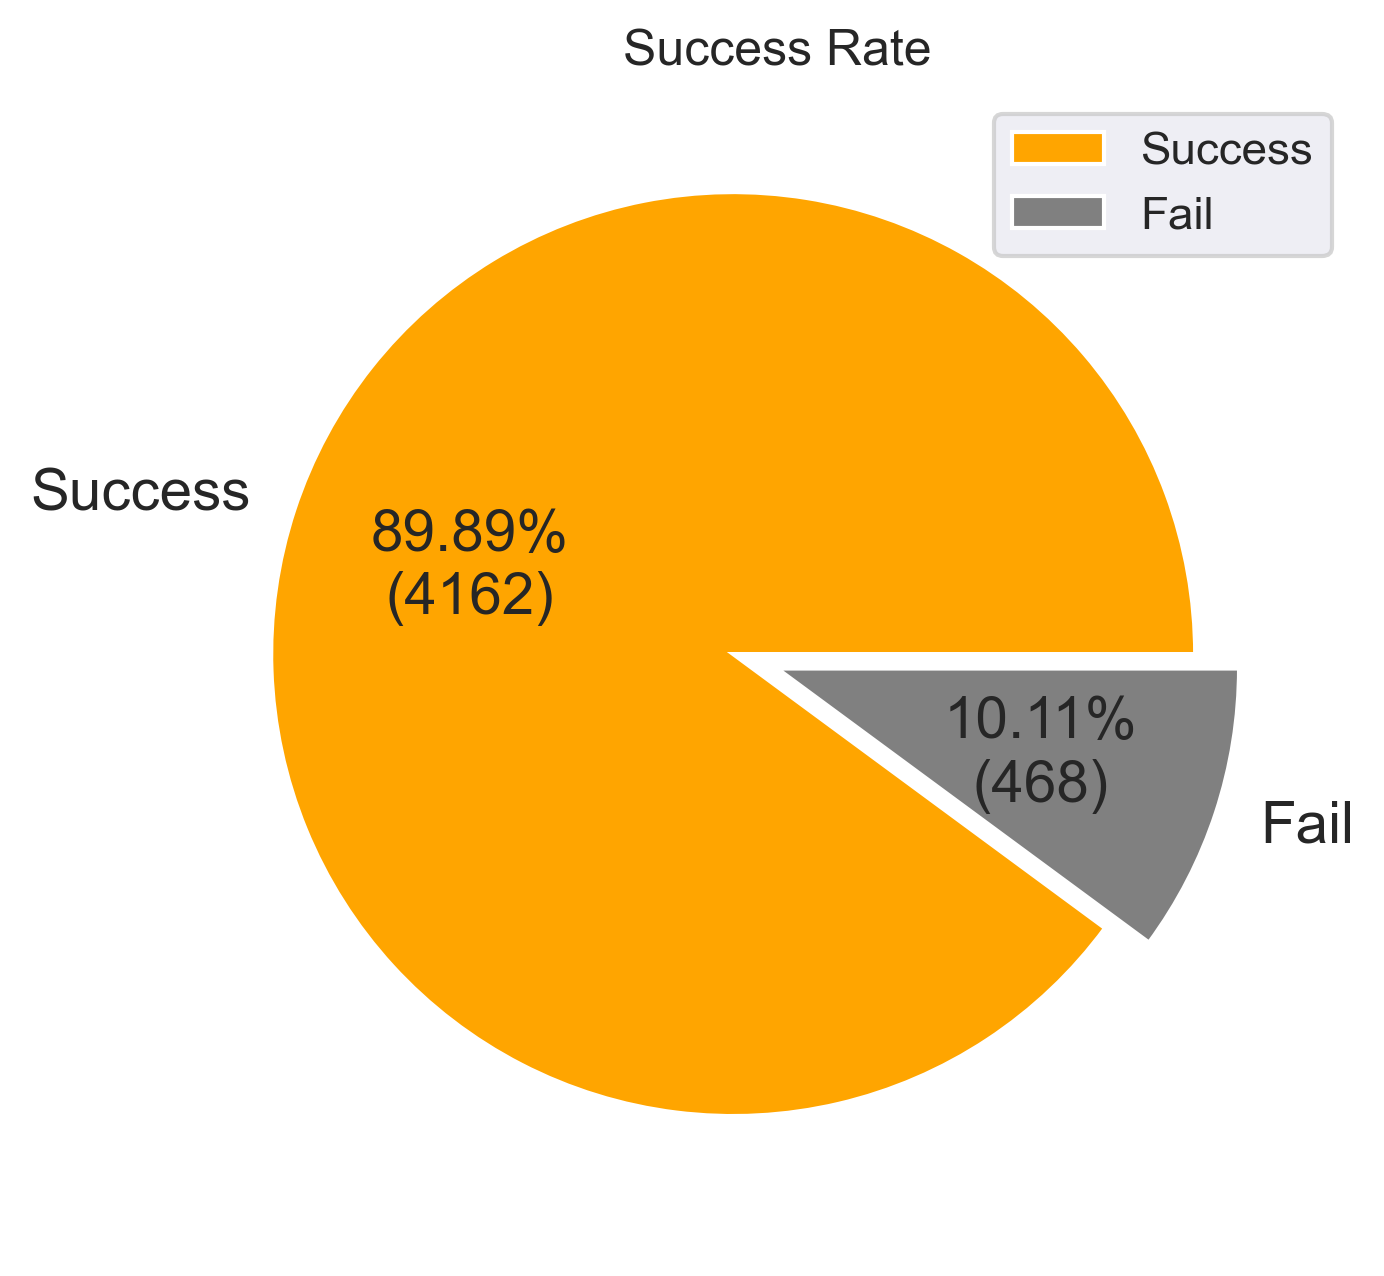

In [3]:
#Clean Data
df = satellite.copy()
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Country'] = df['Location'].str.split(",").str[-1]
df['Country'] = df['Country'].apply(lambda x: x.strip())
#Shahrud Missile Test Site = Iran
df.loc[df['Country'] == 'Shahrud Missile Test Site', 'Country'] = 'Iran'

dfnorm = df.copy()
df_analyze = dfnorm.loc[:,['Year','Country','MissionStatus']]
df_analyze['MissionStatus'] = df_analyze['MissionStatus'].apply(lambda x: 1 if x=='Success' else 0 )
dfgraph_ov = df_analyze['MissionStatus'].value_counts(ascending=False)
sns.set(rc={'figure.figsize':(5,5),'figure.dpi':300})
fig,ax = plt.subplots()
plt.pie(dfgraph_ov, labels = ['Success','Fail'], 
        autopct= lambda x: '{:.2f}%\n({:.0f})'.format(x,x*dfgraph_ov.sum()/100), 
        shadow=False, 
        colors = ['Orange','Gray'], 
        explode = (0.1, 0.0), 
        textprops = dict(fontsize = 14))
plt.legend(['Success','Fail'], loc='upper right')
plt.title('Success Rate')
plt.show()

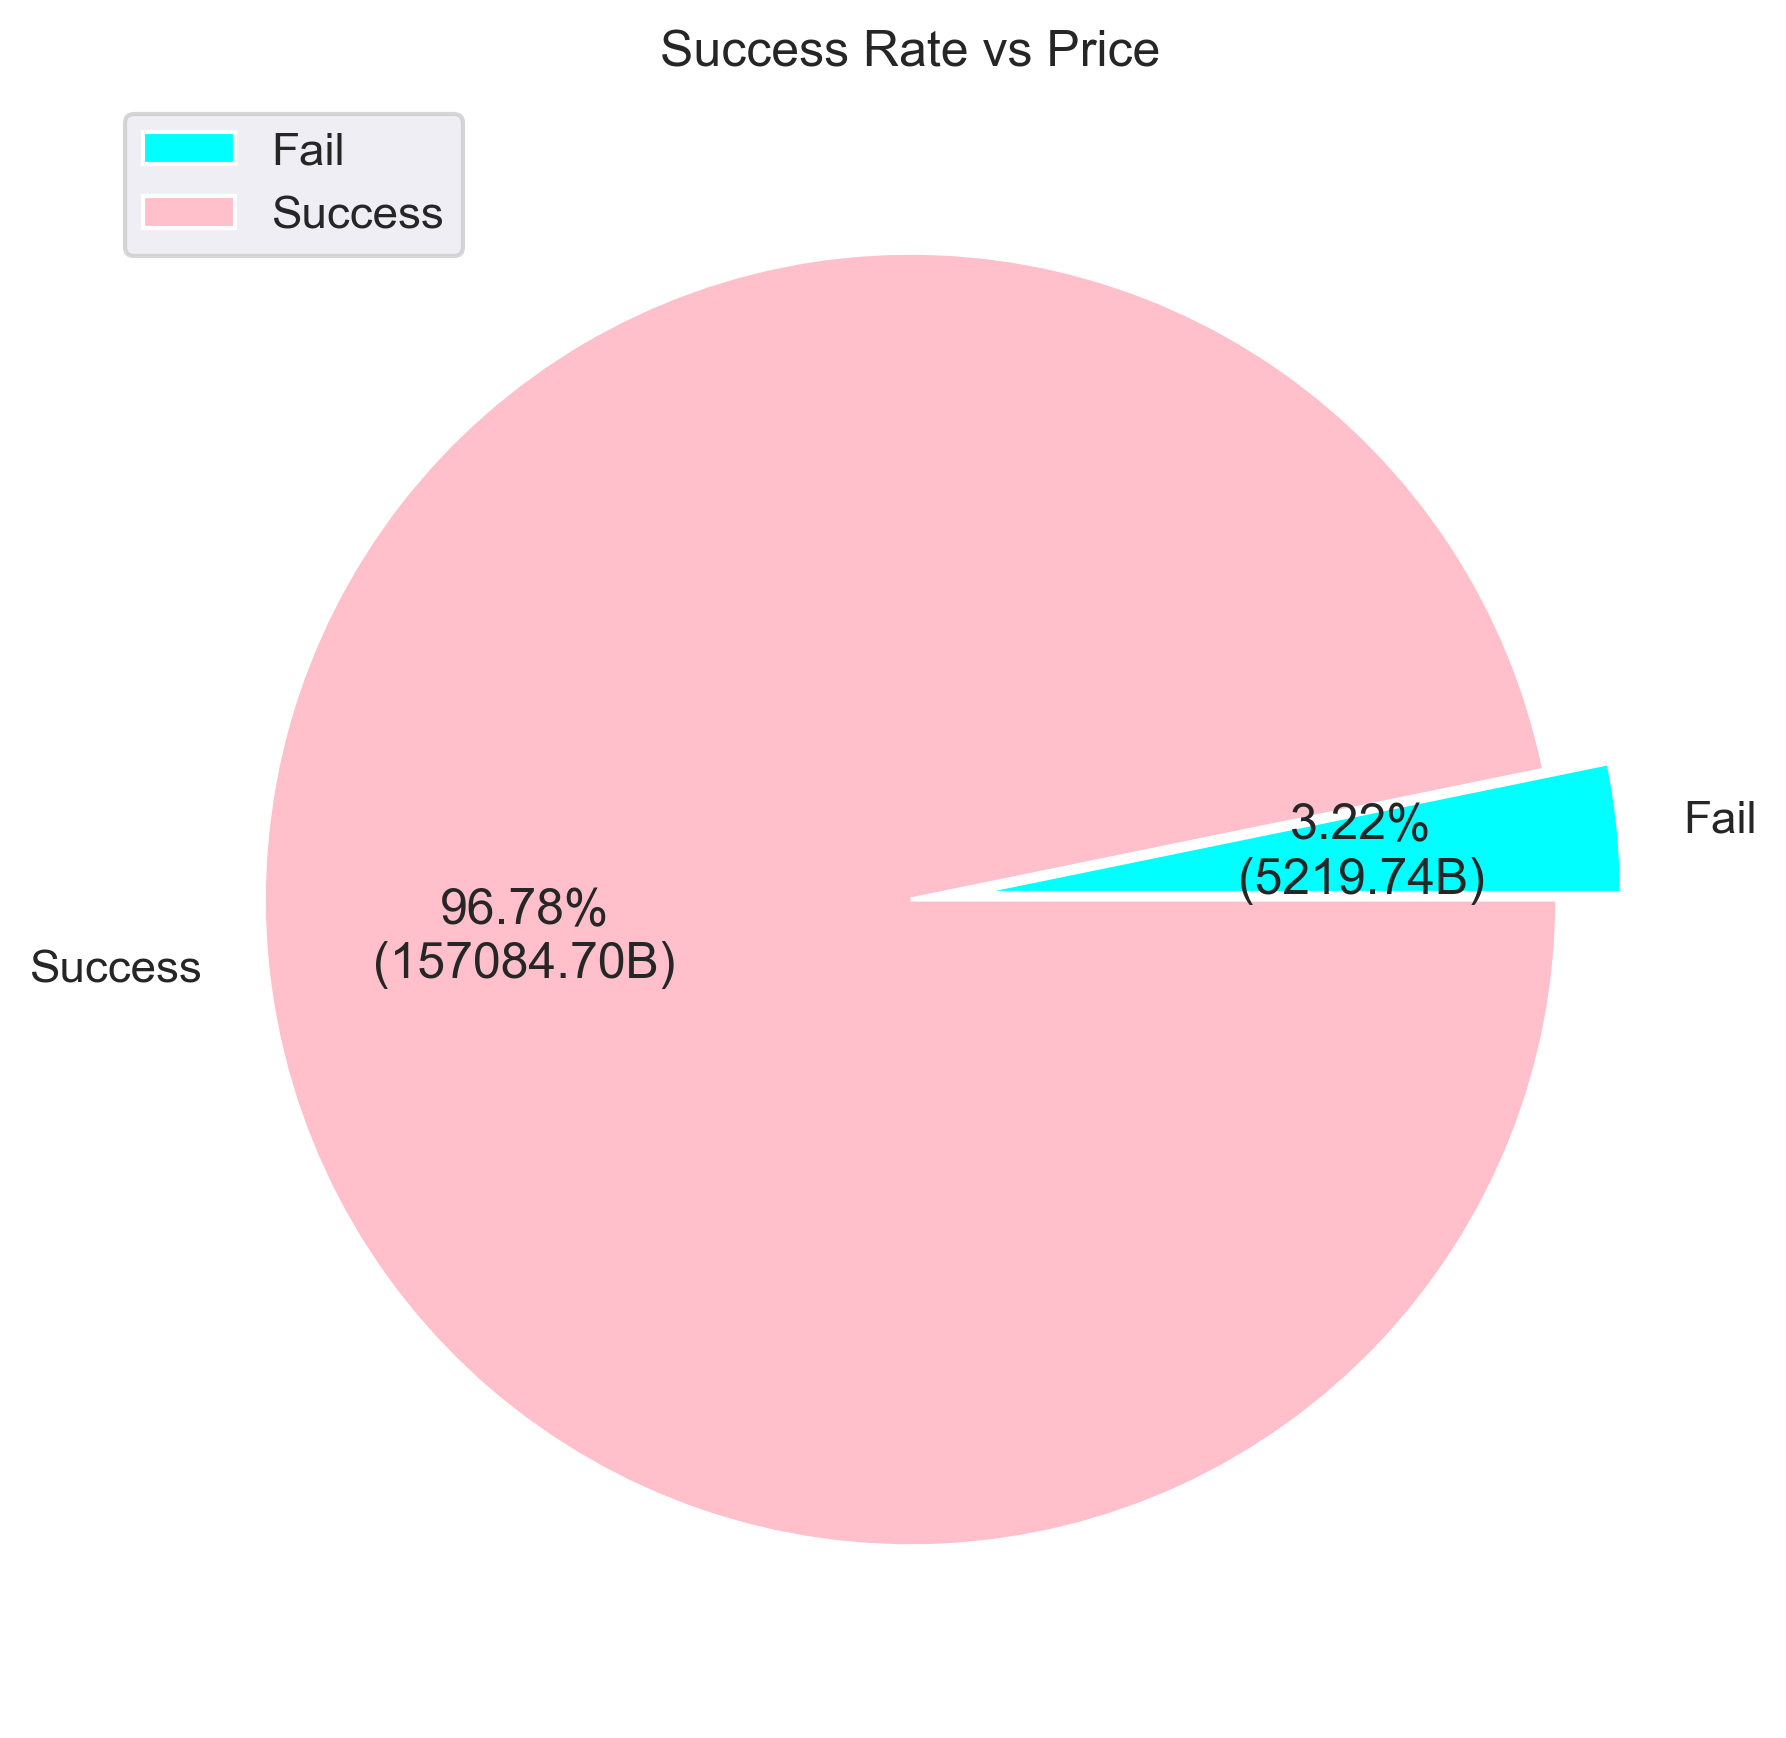

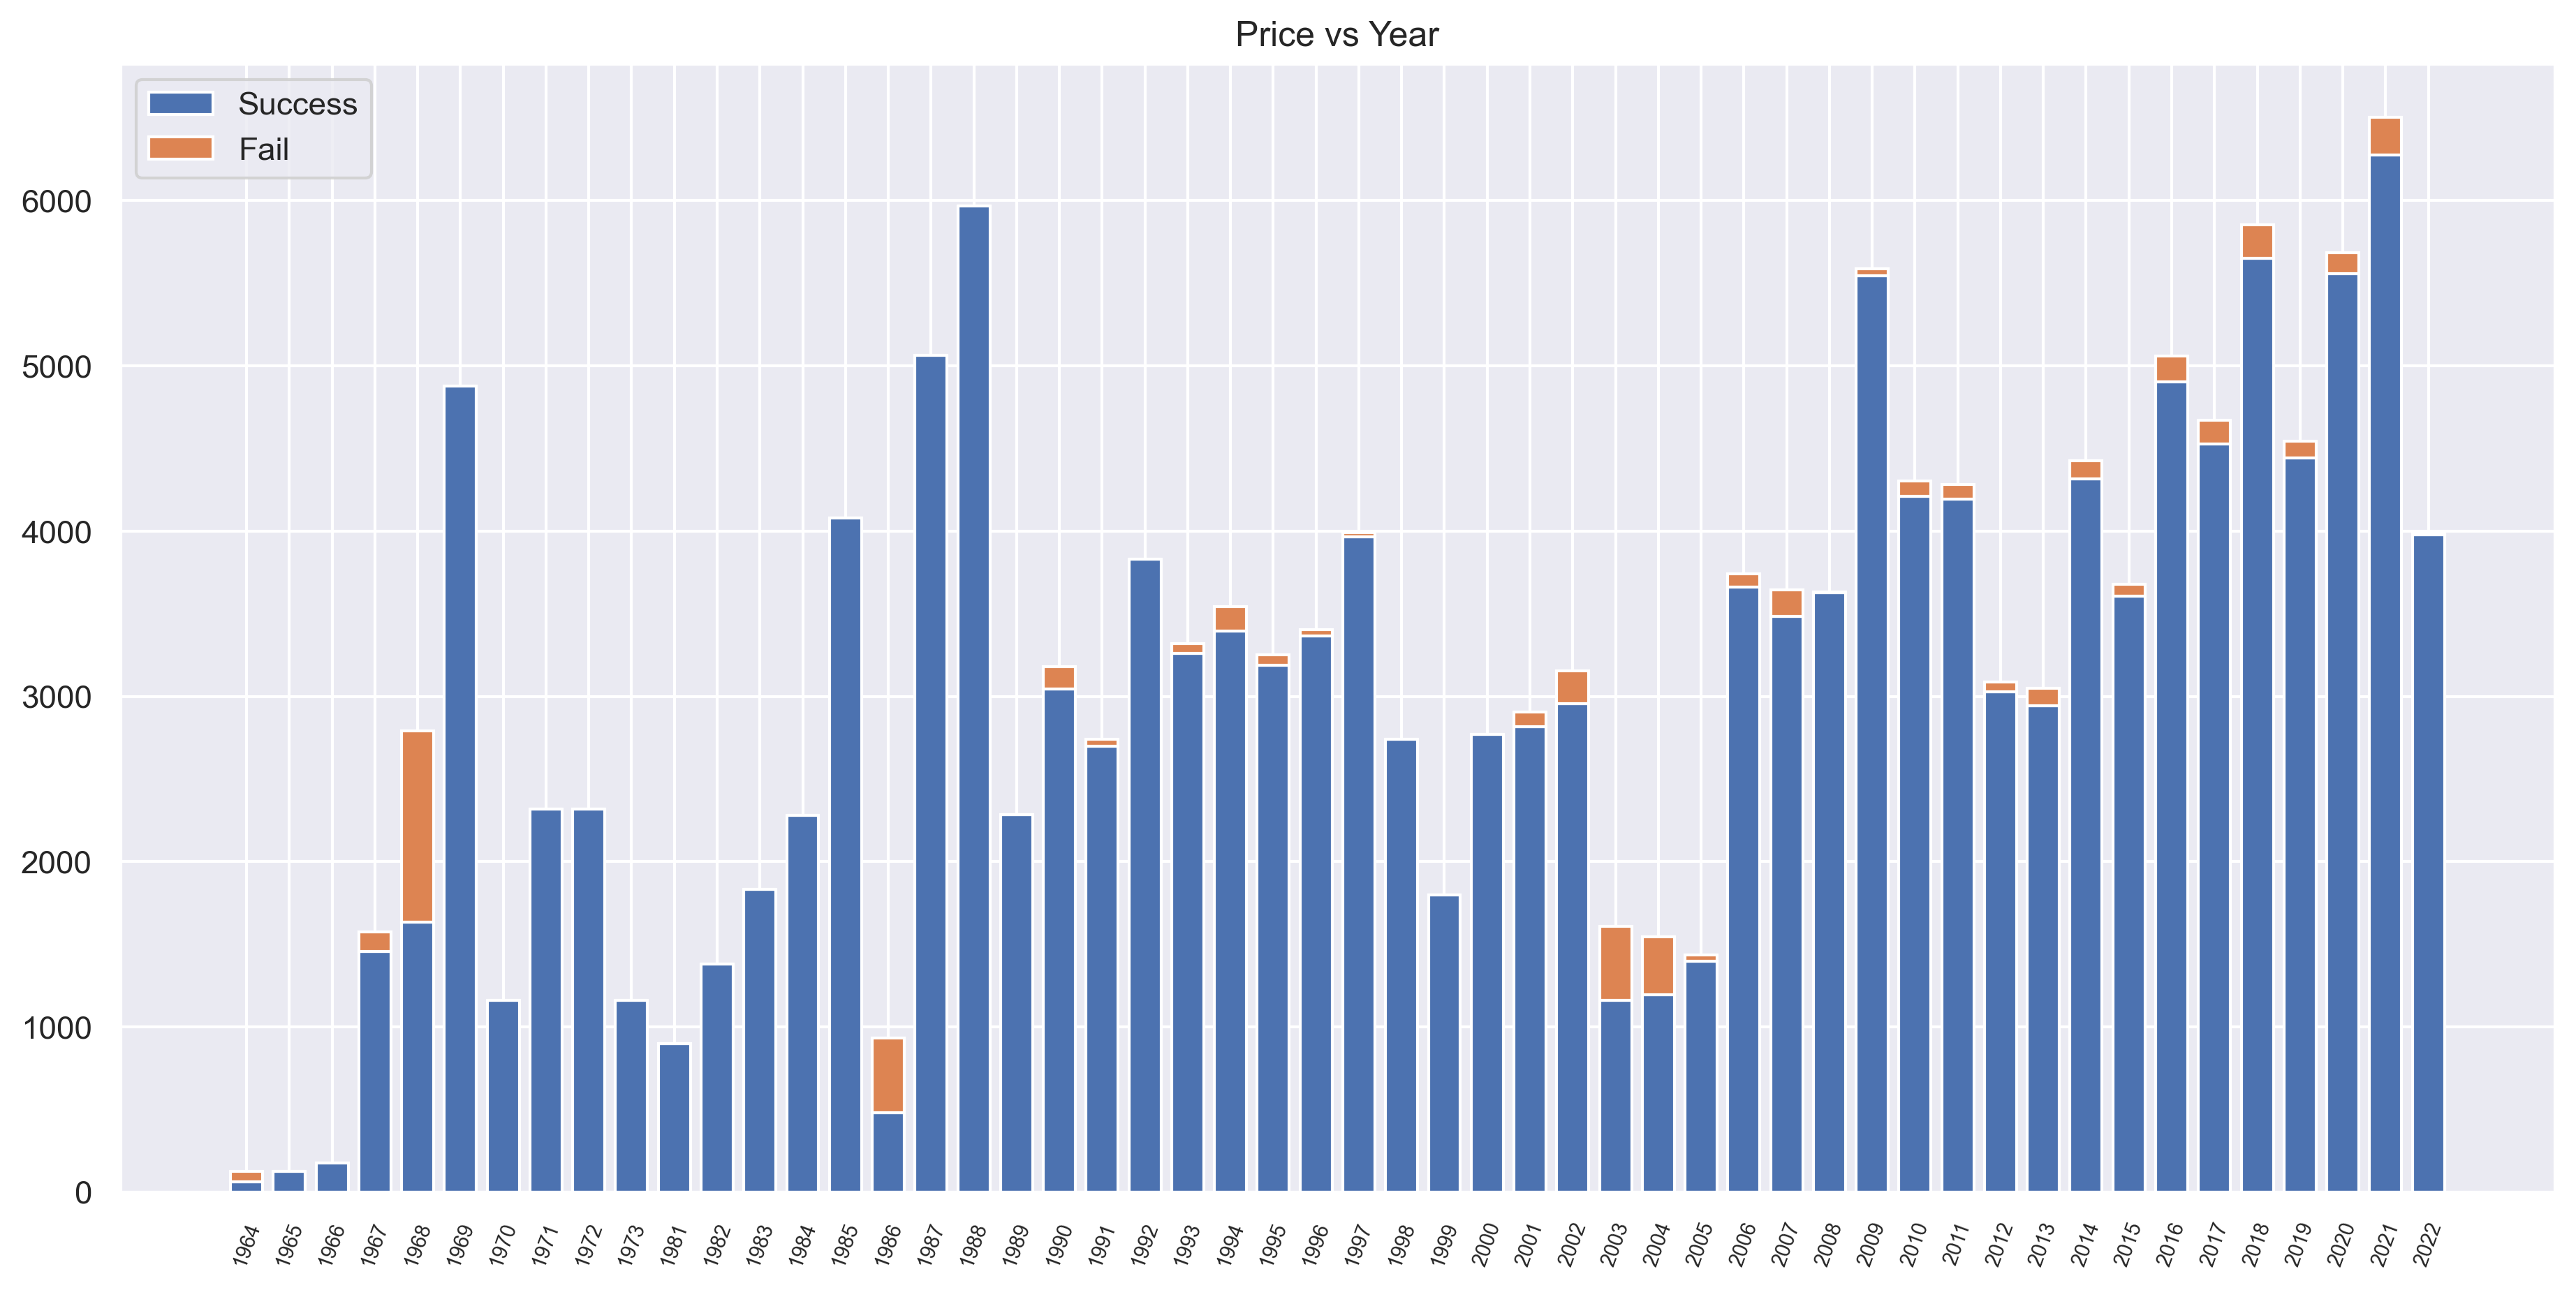

In [4]:
#Remove NA for Price Investigation
df_price = df.copy()
df_price.dropna(subset=['Price'],inplace=True)
df_price['Price'] = df_price['Price'].apply(lambda x: x.replace(',',''))
df_price['Price'] = df_price['Price'].astype(np.float32)
df_analyze1 = df_price.loc[:,['Year','Price','MissionStatus']]

df_analyze1['MissionStatus'] = df_analyze1['MissionStatus'].apply(lambda x: 1 if x=='Success' else 0 )
dfgraph_p1 = df_analyze1.pivot_table( index='MissionStatus', values='Price', aggfunc='sum' )
dfgraph_p1 = dfgraph_p1.fillna(0)

dfgraph_p2 = df_analyze1.pivot_table( index='Year',columns='MissionStatus',values='Price',aggfunc='sum' )
dfgraph_p2 = dfgraph_p2.fillna(0)

sns.set(rc={'figure.figsize':(15,7),'figure.dpi':300})
fig, ax= plt.subplots()
ax.pie(dfgraph_p1['Price'], labels = ['Fail','Success'],
        autopct= lambda x: '{:.2f}%\n({:.2f}B)'.format(x,x*dfgraph_p1['Price'].sum()/100),
        shadow=False,
        colors = ['Cyan','Pink'],
        explode = (0.1, 0.0),)
ax.legend(['Fail','Success'], loc='upper left')
ax.set_title('Success Rate vs Price')

fig, ax= plt.subplots()
year = df_analyze1['Year'].unique()
year = [str(x) for x in year]
ax.bar(year, dfgraph_p2[1].values.tolist(), 0.75)
ax.bar(year, dfgraph_p2[0].values.tolist(), 0.75, bottom = dfgraph_p2[1].values.tolist())
plt.legend(['Success','Fail'], loc='upper left')
ax.xaxis.set_ticks(year)
plt.xticks(rotation=70)
ax.tick_params(axis='x', which='major', labelsize=7)
ax.set_title('Price vs Year')

plt.show()

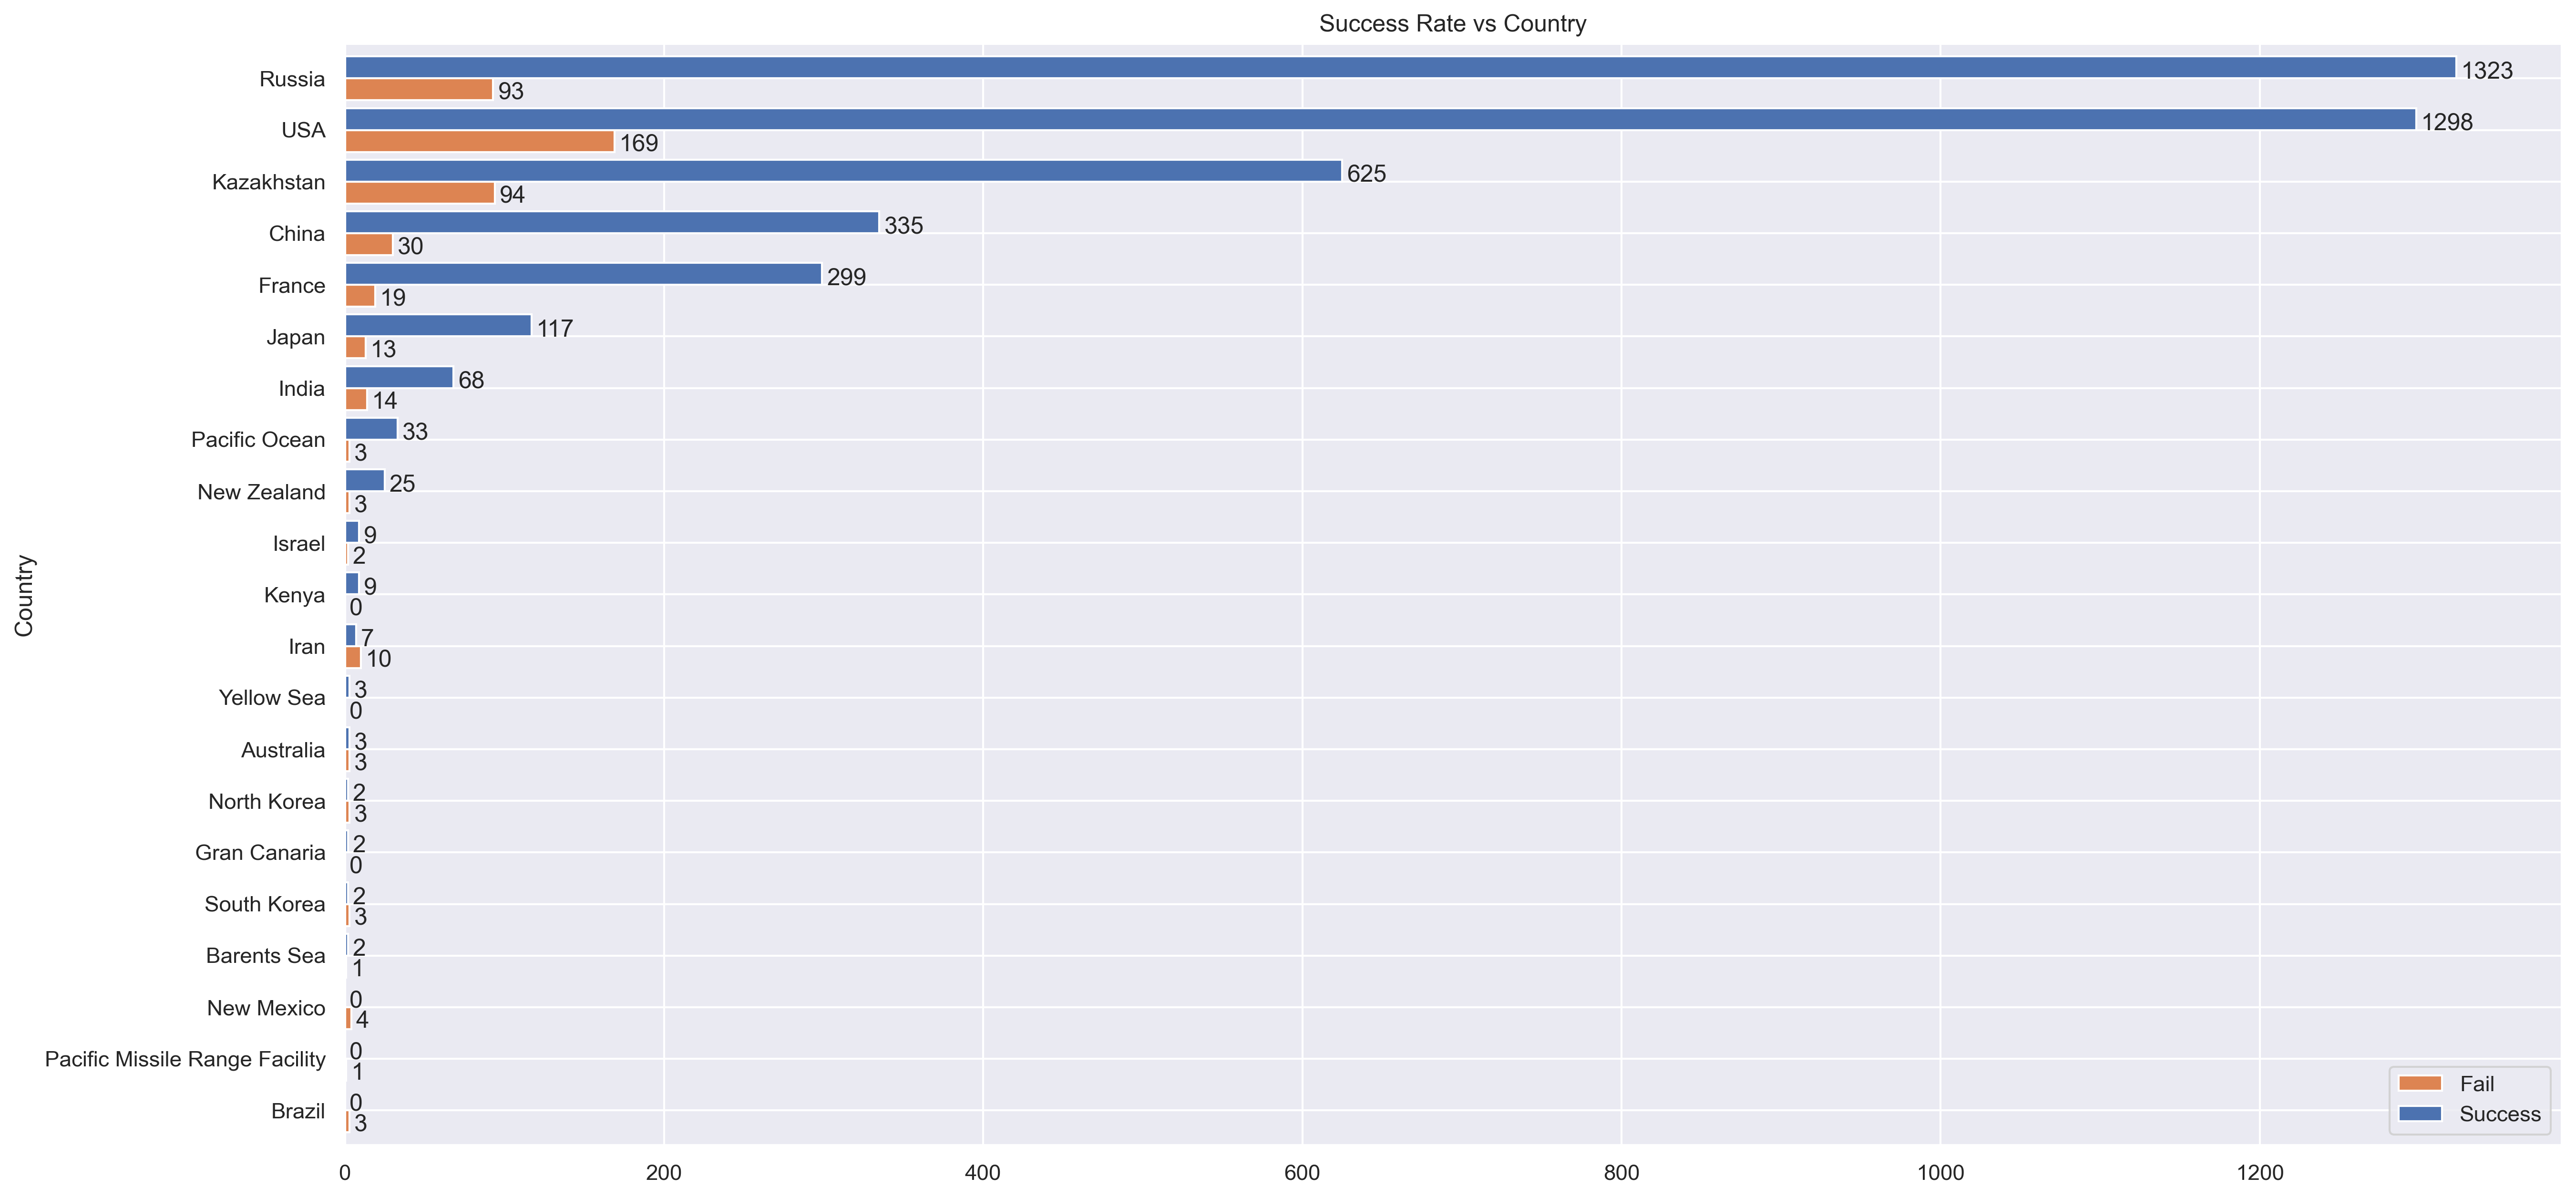

In [5]:
dfgraph_rateCountry = df_analyze.pivot_table( index='Country',
                                              columns='MissionStatus',
                                              values='MissionStatus',
                                              aggfunc='count' )
dfgraph_rateCountry = dfgraph_rateCountry.fillna(0)
dfgraph_rateCountry = dfgraph_rateCountry.sort_values(by=[1],ascending=True)

#Plot
sns.set(rc={'figure.figsize':(20,10),'figure.dpi':300})
palette = sns.color_palette()
ax = dfgraph_rateCountry.plot.barh(ax=plt.axes(),width = 0.85, color = ['C1','C0'])
ax.legend(['Fail','Success'],loc='lower right')
ax = ax.set_title('Success Rate vs Country')
for index, value in enumerate(dfgraph_rateCountry[0]):
    plt.text(value+3, index-0.4, str(int(value)))
for index, value in enumerate(dfgraph_rateCountry[1]):
    plt.text(value+3, index, str(int(value)))

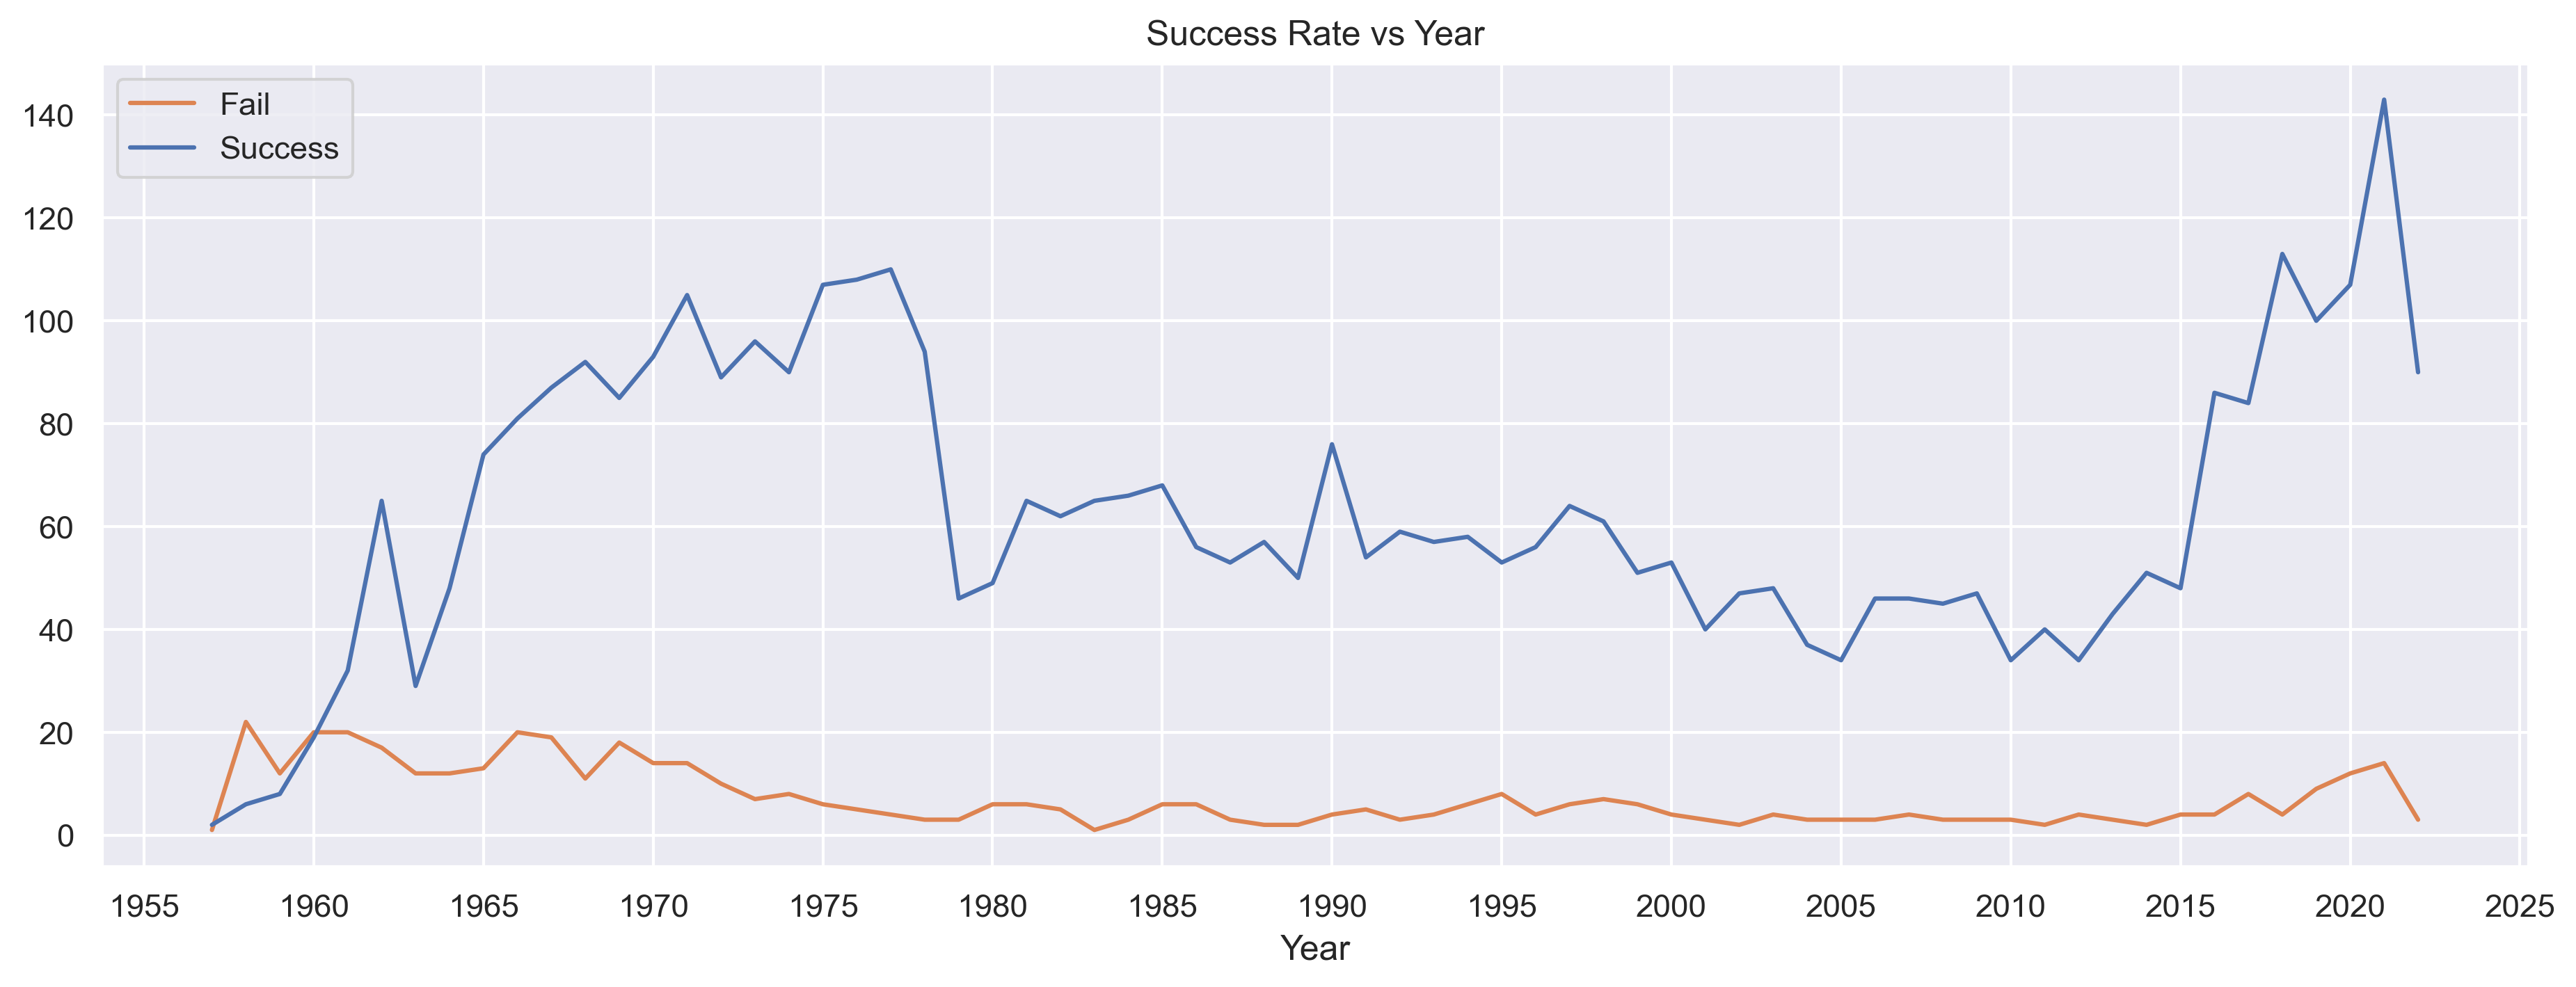

In [6]:
dfgraph_rateYear = df_analyze.pivot_table( index='Year',
                                   columns='MissionStatus', 
                                   values='MissionStatus', 
                                   aggfunc='count' )
dfgraph_rateYear = dfgraph_rateYear.fillna(0)


#dfgraph_rateYear.index = dfgraph_rateYear.index.astype('str')
sns.set(rc={'figure.figsize':(15,5),'figure.dpi':300})
ax = dfgraph_rateYear.plot(ax=plt.axes(), color = ['C1','C0'])
ax.legend(['Fail','Success'],loc='upper left')
ax.set_title('Success Rate vs Year')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

In [7]:
df_final = dfnorm.loc[:,['Year','Country','Price','MissionStatus']]

df_final['MissionStatus'] = df_final['MissionStatus'].apply(lambda x: 1 if x=='Success' else 0 )
df_final['Success'] = df_final['MissionStatus'].apply(lambda x: 1 if x=='Success' else 0 )
df_final['Fail'] = df_final['MissionStatus'].apply(lambda x: 1 if x!='Success' else 0 )
dfgraph = df_final.pivot_table( index=['Year','MissionStatus'], columns='Country', values='Success', aggfunc='count' )
dfgraph = dfgraph.fillna(0)

# frames between transitions
n_frames = 5

x = np.unique(df_final['Country'].values.tolist(),return_index=False)
print('Creating charts')
filenames = []
year = df_final['Year'].unique()
for j,index in enumerate(year):
    # get current and next y coordinates
    if j == len(year)-1:
        break
        
    y = dfgraph.loc[year[j]].values.tolist()
    y1 = dfgraph.loc[year[j+1]].values.tolist()
    
    # calculate the distance to the next position
    y_path = np.array(y1[1]) - np.array(y[1])
    yf_path = np.array(y1[0]) - np.array(y[0])
    for i in np.arange(0, n_frames + 1):
        # divide the distance by the number of frames 
        # and multiply it by the current frame number
        y_temp = (y[1] + (y_path / n_frames) * i)
        yf_temp = (y[0] + (yf_path / n_frames) * i)
        
        # plot
        fig,ax = plt.subplots(figsize=(20,5),dpi=150)
        
        p1 = plt.bar(x, y_temp, 0.75, )
        p2 = plt.bar(x, yf_temp, 0.75, bottom = y_temp)
        plt.legend(['Success','Fail'], loc='upper left')
        
        plt.ylim(0,75)
        ax.xaxis.set_ticks(x)
        plt.xticks(rotation=45)
        title = fig.suptitle('Year '+str(index))
        # build file name and append to list of file names
        filename = f'images/frame_{index}_{i}.png'
        filenames.append(filename)
        # last frame of each stays longer
        if (i == n_frames):
            for i in range(5):
                filenames.append(filename)
        # save img
        plt.savefig(filename,bbox_inches='tight')
        plt.close()
    print('Create Chart for Year ',str(index))
print('Charts saved')
# Build GIF
print('Creating gif')
with imageio.get_writer('06_Year_Country_SuccesRate.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved')
print('DONE')

Creating charts
Create Chart for Year  1957
Create Chart for Year  1958
Create Chart for Year  1959
Create Chart for Year  1960
Create Chart for Year  1961
Create Chart for Year  1962
Create Chart for Year  1963
Create Chart for Year  1964
Create Chart for Year  1965
Create Chart for Year  1966
Create Chart for Year  1967
Create Chart for Year  1968
Create Chart for Year  1969
Create Chart for Year  1970
Create Chart for Year  1971
Create Chart for Year  1972
Create Chart for Year  1973
Create Chart for Year  1974
Create Chart for Year  1975
Create Chart for Year  1976
Create Chart for Year  1977
Create Chart for Year  1978
Create Chart for Year  1979
Create Chart for Year  1980
Create Chart for Year  1981
Create Chart for Year  1982
Create Chart for Year  1983
Create Chart for Year  1984
Create Chart for Year  1985
Create Chart for Year  1986
Create Chart for Year  1987
Create Chart for Year  1988
Create Chart for Year  1989
Create Chart for Year  1990
Create Chart for Year  1991
Crea